**Initial Setup**

In [1]:
!pip install torch
!pip install matplotlib
!pip install torchvision
!pip install cv
!pip install opencv-python
!pip install progressbar

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [2]:
import cv2
import os
import glob
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision 
import torchvision.transforms as T 
from PIL import Image
import random
import cv
import os
import progressbar
from time import sleep

os.environ['KMP_DUPLICATE_LIB_OK']='True'
torch.set_default_tensor_type('torch.FloatTensor')

if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"  
device = torch.device(dev)

img_dir = "Deep Learning Data/face_images" #change to desired dataset directory
out_dir = "Faces" #change to desired output directory, make sure directories are cleared out
fcm = False #false to avoid creating new image files
rm = True #false to disable the regressor
usm = False #true to use saved pretrained Model
sm = True #false to disable saving model

print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
print("File creation mode: ",str(fcm))
print("Regressor mode: ", str(rm))
  

Is CUDA supported by this system? True
CUDA version: 11.1
File creation mode:  False
Regressor mode:  True


**Data Handling**

Imports data from Deep Learning Data Folder and stores it as a data structure

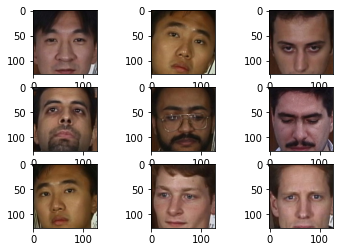

In [3]:
def load_images_from_folder(folder, num):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
            if fcm:
                ret = cv2.imwrite('%s/Augmented/%05d.jpg' % (out_dir,num), img)
            num += 1
    return images

def print_tensor_to_numpy(tensor):
    tensor_reshape = torch.movedim(tensor, 0, 2)
    npimg = tensor_reshape.numpy()
    plt.imshow(npimg[:, :, :])  

k = 0
data = load_images_from_folder(img_dir, k)
data = np.asarray(data)

for i in range(0,9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(cv2.cvtColor(data[i][:,:,:],cv2.COLOR_BGR2RGB))
    
data = torch.from_numpy(data) #converts numpy matrix to tensor
data = torch.movedim(data, 3, 1) #moves the rgb to the second index
data = data[torch.randperm(data.size()[0])]#randomly shuffles tensor along first dim 

In [4]:
def labConvHelper(input):
    conv = cv2.cvtColor(input,cv2.COLOR_BGR2LAB)
    return conv

def convToLab_saveToFile(dataset, saveToFile = False, iter = 0):
    output = []
    outputl = []
    outputa = []
    outputb = []
    for i in range(len(dataset)):
        image = np.asarray(dataset[i,:,:,:])
        image = np.swapaxes(image,1,0)
        image = np.swapaxes(image,1,2)
        imageLAB = labConvHelper(image)
        l,a,b = cv2.split(imageLAB)
        if saveToFile:
            statusL = cv2.imwrite('%s/L/%05d_L.jpg' % (out_dir,iter), l)
            statusa = cv2.imwrite('%s/a/%05d_a.jpg' % (out_dir,iter), a)
            statusb = cv2.imwrite('%s/b/%05d_b.jpg' % (out_dir,iter), b)
        iter += 1
        output.append(imageLAB)
        outputl.append(l)
        outputa.append(a)
        outputb.append(b)
    return np.asarray(output),np.asarray(outputl),np.asarray(outputa),np.asarray(outputb)

**Augment Dataset**

In [5]:
def flip_img(tensor, show =False):
    flipped_img = torch.flip(tensor, (2,))
    if show == True:
        print_tensor_to_numpy(flipped_img)
    return flipped_img

def crop_img(tensor, show = False):
    crop = T.RandomCrop((96,96)) # transform for square crop
    resize_crop = T.Resize((128,128)) #resizes image back to original dimension
    cropped_img = resize_crop(crop(tensor)) 
    if show == True:
        print_tensor_to_numpy(cropped_img)
    return cropped_img

def tint_img(tensor, show = False):
    tint_val = 0.1*random.randrange(6, 10)
    tensor[0, :, :] = tint_val*tensor[0, :, :]
    tensor[1, :, :] = tint_val*tensor[1, :, :]
    tensor[2, :, :] = tint_val*tensor[2, :, :]
    tinted_img = tensor[:, :, :]
    if show == True:
        print_tensor_to_numpy(tinted_img)
    return tinted_img

def create_new_img(tensor, show = False):
    chance = random.randrange(0, 10)
    #60% chance of only one transformation
    if (chance < 2):
        new_img = flip_img(tensor) 
    elif (chance >= 2 and chance <4):
        new_img = crop_img(tensor)
    elif (chance >= 4 and chance <6):
        new_img = tint_img(tensor)
    #40% chance of more complex transformations
    elif (chance >= 6 and chance <8):
        tensor_cropped = crop_img(tensor)
        tensor_tinted = tint_img(tensor_cropped)
        new_img = tensor_tinted
    elif (chance >= 8 and chance <=10):
        tensor_flipped = flip_img(tensor) 
        tensor_cropped = crop_img(tensor_flipped)
        tensor_tinted = tint_img(tensor_cropped)
        new_img = tensor_tinted
        
    if show == True:
        print_tensor_to_numpy(new_img)
        
    return new_img

In [6]:
#image path to tensor converter
def pathToTensor(inString):
    inDat = labConvHelper(cv2.imread(inString))
    inDat = np.swapaxes(inDat,1,2)
    inDat = np.swapaxes(inDat,0,1)
    tmpx, tmpa, tmpb= np.array_split(inDat,3)
    tmpx = torch.from_numpy(tmpx[np.newaxis,:,:,:]/255).to(torch.float32).to(device)
    return tmpx

In [7]:
#for loop which appends the newly created images (takes a while)
k = len(data)
k_old = len(data)

upperRange = 7 #set this to generate data

totalIter = k_old * (upperRange+1)-k_old
bar = progressbar.ProgressBar(maxval=totalIter, \
    widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
bar.start()

for j in range(upperRange):
    for i in range(0, k_old):
        new_img = create_new_img(data[i, :, :, :])
        new_img = new_img[None, :, :, :] #extending the dimensions so that vector can be appended
        data = torch.cat((data, new_img), 0)
        tmp = new_img.numpy()
        tmp = tmp[0].swapaxes(0,1)
        tmp = tmp.swapaxes(1,2)
        if fcm:
            ret = cv2.imwrite('%s/Augmented/%05d_A.jpg' % (out_dir,k), tmp)
        if k-k_old < totalIter:
            bar.update(k-k_old)
        k += 1
        
bar.finish()
        
print("Done augmenting data...")
imageLab, l, a, b = convToLab_saveToFile(data, fcm, len(data))
imageLab = np.swapaxes(imageLab,2,3)
imageLab = np.swapaxes(imageLab,1,2)
print("Done converting")

[========================================================================] 100%


Done augmenting data...
Done converting


In [32]:
#Prepare data for regression
# normData = torch.from_numpy(l).to(torch.float32)
# normData = normData.unsqueeze(1)
bs = 32
x_set = l
x_set = x_set[:,np.newaxis,:,:]

x_set = x_set/255
y_set = np.asarray([a,b])
y_set = y_set.swapaxes(0,1)
y_setR = np.expand_dims(np.expand_dims(y_set.mean(axis = 2).mean(axis = 2), axis = 2), axis = 2)
norm_abR = y_setR/255
norm_abC = y_set/255

vIndex = int(np.ceil(len(x_set)*0.9))

train_datasetR = torch.utils.data.TensorDataset(torch.from_numpy(x_set[0:vIndex]).to(torch.float32), torch.from_numpy(norm_abR[0:vIndex]).to(torch.float32))
train_loaderR = torch.utils.data.DataLoader(dataset=train_datasetR, 
                                        batch_size=bs, 
                                        shuffle=True)

validation_datasetR = torch.utils.data.TensorDataset(torch.from_numpy(x_set[vIndex:]).to(torch.float32), torch.from_numpy(norm_abR[vIndex:]).to(torch.float32))
validation_loaderR = torch.utils.data.DataLoader(dataset=validation_datasetR,
                                        batch_size=bs,
                                        shuffle=True)

train_datasetC = torch.utils.data.TensorDataset(torch.from_numpy(x_set[0:vIndex]).to(torch.float32), torch.from_numpy(norm_abC[0:vIndex]).to(torch.float32))
train_loaderC = torch.utils.data.DataLoader(dataset=train_datasetC, 
                                        batch_size=bs, 
                                        shuffle=True)

validation_datasetC = torch.utils.data.TensorDataset(torch.from_numpy(x_set[vIndex:]).to(torch.float32), torch.from_numpy(norm_abC[vIndex:]).to(torch.float32))
validation_loaderC = torch.utils.data.DataLoader(dataset=validation_datasetC,
                                        batch_size=bs,
                                        shuffle=True)

**Regressor**

Finds mean chrominance across the entire greyscale image using spatial convolution

In [33]:
%%time

class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 128, kernel_size=3, stride = 2, padding = 1)
        self.c1bn = nn.BatchNorm2d(128)
        self.conv2 = nn.Conv2d(in_channels = 128, out_channels = 64, kernel_size=3, stride = 2, padding = 1)
        self.c2bn = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels = 64, out_channels = 32, kernel_size=3, stride = 2, padding = 1)
        self.c3bn = nn.BatchNorm2d(32)
        self.conv4 = nn.Conv2d(in_channels = 32, out_channels = 16, kernel_size=3, stride = 2, padding = 1)
        self.c4bn = nn.BatchNorm2d(16)
        self.conv5 = nn.Conv2d(in_channels = 16, out_channels = 8, kernel_size=3, stride = 2, padding = 1)
        self.c5bn = nn.BatchNorm2d(8)
        self.conv6 = nn.Conv2d(in_channels = 8, out_channels = 4, kernel_size=3, stride = 2, padding = 1)
        self.c6bn = nn.BatchNorm2d(4)
        self.conv7 = nn.Conv2d(in_channels = 4, out_channels = 2, kernel_size=3, stride = 2, padding = 1)
        self.c7bn = nn.BatchNorm2d(2)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.c1bn(x))
        x = self.conv2(x)
        x = F.relu(self.c2bn(x))
        x = self.conv3(x)
        x = F.relu(self.c3bn(x))
        x = self.conv4(x)
        x = F.relu(self.c4bn(x))
        x = self.conv5(x)
        x = F.relu(self.c5bn(x))
        x = self.conv6(x)
        x = F.relu(self.c6bn(x))
        x = self.conv7(x)
        x = F.relu(self.c7bn(x))
        return x
        
if rm:
    model = NN().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
    criterion = nn.MSELoss().to(device)
    
    for epoch in range(100):
        model.train()
        loss = 0 
        for i, (L_data, ab_data) in enumerate(train_loaderR):
            model.train()
            L_data = L_data.to(device)
            ab_data = ab_data.to(device)
            optimizer.zero_grad()
            outputs = model(L_data).to(device)
            loss = criterion(outputs, ab_data)
            loss.backward()
            optimizer.step()
        model.eval()
        runningloss = 0
        for j, (vL_data, vab_data) in enumerate(validation_loaderR):
            vL_data = vL_data.to(device)
            vab_data = vab_data.to(device)
            voutputs = model(vL_data).to(device)
            vloss = criterion(voutputs, vab_data)
            runningloss += vloss.item()
        vloss = runningloss/(j+1)
        print ('Epoch [{}/{}], Training Loss: {}, Validation Loss: {}'.format(epoch+1, 100 ,loss.item(), vloss))
    

Epoch [1/100], Training Loss: 0.10520242154598236, Validation Loss: 0.019504307205543706
Epoch [2/100], Training Loss: 0.03940813988447189, Validation Loss: 0.010187477841483135
Epoch [3/100], Training Loss: 0.026387255638837814, Validation Loss: 0.008063512088387813
Epoch [4/100], Training Loss: 0.027008531615138054, Validation Loss: 0.005070040979741239
Epoch [5/100], Training Loss: 0.0269109308719635, Validation Loss: 0.004710699256975204
Epoch [6/100], Training Loss: 0.013516126200556755, Validation Loss: 0.016536351986456123
Epoch [7/100], Training Loss: 0.13796217739582062, Validation Loss: 0.05208748088855492
Epoch [8/100], Training Loss: 0.027782097458839417, Validation Loss: 0.011202468472459403
Epoch [9/100], Training Loss: 0.029283909127116203, Validation Loss: 0.01792921976333386
Epoch [10/100], Training Loss: 0.014044283889234066, Validation Loss: 0.006680777242811593
Epoch [11/100], Training Loss: 0.026796987280249596, Validation Loss: 0.00559094698952609
Epoch [12/100], 

In [34]:
#Use Regressor
if rm:
    model.eval()

    inputData = x_set[128]

    indata = torch.from_numpy(np.expand_dims(inputData,axis = 0)).to(device).type(torch.float32)
    print(indata.dtype)
    outReg = model(indata).to(device)
    print("Results of regression: ", np.squeeze(outReg.detach().cpu().clone().numpy()))

torch.float32
Results of regression:  [0.51192784 0.5123684 ]


**Colorizer**

This is built on the previous regressor with extra upscaling and convolution layers in between.

In [49]:
%%time
#Model, training, and validation for the colorizer
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 128, kernel_size=3, stride = 2, padding = 1)
        self.c1bn = nn.BatchNorm2d(128)
        self.conv2 = nn.Conv2d(in_channels = 128, out_channels = 64, kernel_size=3, stride = 2, padding = 1)
        self.c2bn = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels = 64, out_channels = 32, kernel_size=3, stride = 2, padding = 1)
        self.c3bn = nn.BatchNorm2d(32)
        self.conv4 = nn.Conv2d(in_channels = 32, out_channels = 16, kernel_size=3, stride = 2, padding = 1)
        self.c4bn = nn.BatchNorm2d(16)
        self.conv5 = nn.Conv2d(in_channels = 16, out_channels = 8, kernel_size=3, stride = 2, padding = 1)
        self.c5bn = nn.BatchNorm2d(8)
        self.conv6 = nn.Conv2d(in_channels = 8, out_channels = 4, kernel_size=3, stride = 2, padding = 1)
        self.c6bn = nn.BatchNorm2d(4)
        self.conv7 = nn.Conv2d(in_channels = 4, out_channels = 2, kernel_size=3, stride = 2, padding = 1)
        self.c7bn = nn.BatchNorm2d(2)
        
        self.u1 = nn.Upsample(scale_factor=2, mode='nearest')
        self.u2 = nn.Upsample(scale_factor=2, mode='nearest')
        self.u3 = nn.Upsample(scale_factor=2, mode='nearest')
        self.u4 = nn.Upsample(scale_factor=2, mode='nearest')
        self.u5 = nn.Upsample(scale_factor=2, mode='nearest')
        self.u6 = nn.Upsample(scale_factor=2, mode='nearest')
        self.u7 = nn.Upsample(scale_factor=2, mode='nearest')

        self.conv8 = nn.Conv2d(in_channels=2, out_channels=3, kernel_size=3, stride = 1, padding = 1)
        self.conv9 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride = 1, padding = 1)
        self.conv10 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride = 1, padding = 1)
        self.conv11 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride = 1, padding = 1)
        self.conv12 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride = 1, padding = 1)
        self.conv13 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride = 1, padding = 1)
        self.conv14 = nn.Conv2d(in_channels=3, out_channels=2, kernel_size=3, stride = 1, padding = 1)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.c1bn(x))
        x = self.conv2(x)
        x = F.relu(self.c2bn(x))
        x = self.conv3(x)
        x = F.relu(self.c3bn(x))
        x = self.conv4(x)
        x = F.relu(self.c4bn(x))
        x = self.conv5(x)
        x = F.relu(self.c5bn(x))
        x = self.conv6(x)
        x = F.relu(self.c6bn(x))
        x = self.conv7(x)
        x = F.relu(self.c7bn(x))
        x = self.u1(x)
        x = self.conv8(x)
        x = F.relu(x)
        x = self.u2(x)
        x = self.conv9(x)
        x = F.relu(x)
        x = self.u3(x)
        x = self.conv10(x)
        x = F.relu(x)
        x = self.u4(x)
        x = self.conv11(x)
        x = F.relu(x)
        x = self.u5(x)
        x = self.conv12(x)
        x = F.relu(x)
        x = self.u6(x)
        x = self.conv13(x)
        x = F.relu(x)
        x = self.conv14(x)
        x = F.relu(x)
        x = self.u7(x)
        return x
        
if not usm:
    model = NN().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
    criterion = nn.MSELoss().to(device)

    for epoch in range(100):
        model.train() 
        for i, (L_data, ab_data) in enumerate(train_loaderC):
            L_data = L_data.to(device)
            ab_data = ab_data.to(device)
            optimizer.zero_grad()
            outputs = model(L_data).to(device)
            loss = criterion(outputs, ab_data)
            loss.backward()
            optimizer.step()
        model.eval()
        runningloss = 0
        for j, (vL_data, vab_data) in enumerate(validation_loaderC):
            vL_data = vL_data.to(device)
            vab_data = vab_data.to(device)
            voutputs = model(vL_data).to(device)
            vloss = criterion(voutputs, vab_data)
            runningloss += vloss.item()
        vloss = runningloss/(j+1)
        print ('Epoch [{}/{}], Training Loss: {}, Validation Loss: {}'.format(epoch+1, 100 ,loss.item(), vloss))   

Epoch [1/100], Training Loss: 0.005040768533945084, Validation Loss: 0.0049781151802132
Epoch [2/100], Training Loss: 0.003332877065986395, Validation Loss: 0.00311828882580525
Epoch [3/100], Training Loss: 0.0023329821415245533, Validation Loss: 0.0023098745456847703
Epoch [4/100], Training Loss: 0.0020756730809807777, Validation Loss: 0.0018579498006913223
Epoch [5/100], Training Loss: 0.0016029406106099486, Validation Loss: 0.0015485236837871764
Epoch [6/100], Training Loss: 0.001424181624315679, Validation Loss: 0.0013330589097581412
Epoch [7/100], Training Loss: 0.0013620102545246482, Validation Loss: 0.001178696861882743
Epoch [8/100], Training Loss: 0.0010808686492964625, Validation Loss: 0.0010518210229316825
Epoch [9/100], Training Loss: 0.0009208534611389041, Validation Loss: 0.0009129754800692593
Epoch [10/100], Training Loss: 0.0007073450833559036, Validation Loss: 0.0006640394414333921
Epoch [11/100], Training Loss: 0.0007132035098038614, Validation Loss: 0.000464528083715

In [50]:
#Save the model
if (not usm) and sm:
    torch.save(model.state_dict(), "Saved Model")

**************************
External image testing:


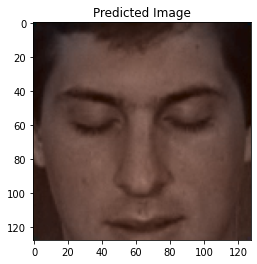

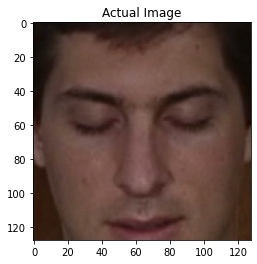

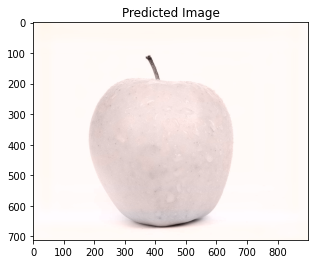

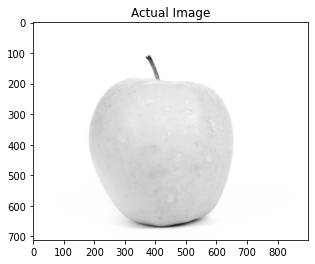

In [54]:
#Testing Model
if usm:
    model = NN().to(device)
    model.load_state_dict(torch.load("Saved Model"))
    model.eval()

fig, axs = plt.subplot(3,3)
axs[0,0].set_title('Actual Image')
axs[0,1].set_title('L* Channel')
axs[0,2].set_title('Predicted Image')

for i in range(3):
    tmpx = torch.from_numpy(np.expand_dims(x_set[7**(i+1)],axis=0)).to(torch.float32).to(device)
    model.eval()
    out = np.expand_dims(model(tmpx).detach().cpu().clone().numpy(), axis = 0)
    tmp = np.concatenate((tmpx.detach().cpu().clone().numpy()*100, out[0]*255-128), axis = 1)
    pred = tmp[0]
    known = imageLab[7**(i+1)]

    tmpN = np.swapaxes(pred,0,1)
    tmpN = np.swapaxes(tmpN,1,2)
    tmp2 = np.swapaxes(known,0,1)
    tmp2 = np.swapaxes(tmp2,1,2)
    tmpN = (np.round(tmpN))

    im = cv2.cvtColor(tmpN,cv2.COLOR_Lab2BGR)
    im2 = cv2.cvtColor(tmp2, cv2.COLOR_Lab2BGR)

    axs[i,0].imshow(cv2.cvtColor(im2,cv2.COLOR_BGR2RGB))
    axs[i,1].imshow(cv2.cvtColor(im2,cv2.COLOR_BGR2LAB)[:,:,0])
    axs[i,2].imshow(cv2.cvtColor(im,cv2.COLOR_BGR2RGB))

axs[0,0].imshow()
plt.figure()
plt.title("Predicted Image")
plt.imshow(cv2.cvtColor(im,cv2.COLOR_BGR2RGB))
plt.figure()
plt.title("Actual Image")
plt.imshow(cv2.cvtColor(im2,cv2.COLOR_BGR2RGB))

print("**************************")
print("External image testing:")

path = "Deep Learning Data/Gray/Apple/Apple1.jpg"

inDat = labConvHelper(cv2.imread(path))
inDat = np.swapaxes(inDat,1,2)
inDat = np.swapaxes(inDat,0,1)
tmpx, tmpa, tmpb= np.array_split(inDat,3)

tmpx = torch.from_numpy(tmpx[np.newaxis,:,:,:]/255).to(torch.float32).to(device)
h = tmpx.shape[2]
w = tmpx.shape[3]
out = model(tmpx)
out = nn.Upsample(size = (h,w), mode = 'nearest')(out).detach().cpu().clone().numpy()

tmp = np.concatenate((tmpx[0].detach().cpu().clone().numpy()[np.newaxis,:,:,:]*100, out*255-128),axis = 1)
pred = tmp[0]
known = inDat

tmpN = np.swapaxes(pred,0,1)
tmpN = np.swapaxes(tmpN,1,2)
tmp2 = np.swapaxes(known,0,1)
tmp2 = np.swapaxes(tmp2,1,2)
tmpN = (np.round(tmpN))

im = cv2.cvtColor(tmpN,cv2.COLOR_Lab2BGR)
im2 = cv2.cvtColor(tmp2, cv2.COLOR_Lab2BGR)

plt.figure()
plt.title("Predicted Image")
plt.imshow(cv2.cvtColor(im,cv2.COLOR_BGR2RGB))
plt.figure()
plt.title("Actual Image")
plt.imshow(cv2.cvtColor(im2,cv2.COLOR_BGR2RGB))